<a href="https://colab.research.google.com/github/CeesGniewyk/Recommender-Systems/blob/master/Assignment_3_1_1_Document_Level_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 3.1. Sequence Classification**

Cees Gniewyk - 0859034 <br>
Celine Senden - 0865165 <br>
Timothy de Vries - 0740585

# Hyperparameters for learning

In [0]:
dropout = 0.5
batch_size = 64
epochs = 30
patience = 5

# Preparation

## Mounting Google and Installing Packages

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
import os
import sys
import codecs
import operator
import numpy as np
import re
from time import time
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
import _pickle as cPickle
import operator
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Input, CuDNNLSTM, Bidirectional
from keras.models import Model, Sequential
import keras.optimizers as opt
import matplotlib.pyplot as plt

## Importing Data

In [0]:
data_path = 'Colab Notebooks/Assignment 3/Data/doc_level'
uni_checkpoint_path = 'Colab Notebooks/Assignment 3/Checkpoints/Unidirectional'
bi_checkpoint_path = 'Colab Notebooks/Assignment 3/Checkpoints/Bidirectional'

### Reading preprocess data

In [0]:
def read_pickle(data_path, file_name):

    f = open(os.path.join(data_path, file_name), 'rb')
    read_file = cPickle.load(f)
    f.close()

    return read_file

def save_pickle(data_path, file_name, data):

    f = open(os.path.join(data_path, file_name), 'wb')
    cPickle.dump(data, f)
    print(" file saved to: %s"%(os.path.join(data_path, file_name)))
    f.close()

In [0]:
words_idx = read_pickle(data_path, 'words_idx.pkl')
idx_words = read_pickle(data_path, 'idx_words.pkl')
data = read_pickle(data_path, 'data.pkl')
label = read_pickle(data_path, 'label.pkl')

## Preparing Training and Validation Set

In [0]:
rand_idx = np.arange(len(data))
np.random.shuffle(rand_idx)

data = data[rand_idx]
label = to_categorical(label)[rand_idx]

data_size = len(data)

test_x = data[0:1000]
test_y = label[0:1000]

dev_x = data[1000:5000]
dev_y = label[1000:5000]

train_x = data[5000:int(data_size)]
train_y = label[5000:int(data_size)]

In [0]:
maxlen = 300
words_idx = [x for (x, _) in sorted(words_idx.items(), key=operator.itemgetter(1))]
train_x_ = sequence.pad_sequences(train_x, maxlen)
dev_x_ = sequence.pad_sequences(dev_x, maxlen)
test_x_ = sequence.pad_sequences(test_x, maxlen)
train_x_ = np.array(train_x_)
train_y = np.array(train_y)

dev_x_ = np.array(dev_x_)
dev_y = np.array(dev_y)

test_x_ = np.array(test_x_)
test_y = np.array(test_y)

### Data Iterator

In [0]:
class Dataiterator():
    '''
      1) Iteration over minibatches using next(); call reset() between epochs to randomly shuffle the data
      2) Access to the entire dataset using all()
    '''
    
    def __init__(self, X, y, seq_length=32, decoder_dim=300, batch_size=32):      
        self.X = X 
        self.y = y 
        self.num_data = len(X) # total number of examples
        self.batch_size = batch_size # batch size
        self.reset() # initial: shuffling examples and set index to 0
    
    def __iter__(self): # iterates data
        return self


    def reset(self): # initials
        self.idx = 0
        self.order = np.random.permutation(self.num_data) # shuffling examples by providing randomized ids 
        
    def __next__(self): # return model inputs - outputs per batch
        X_ids = [] # hold ids per batch 
        while len(X_ids) < self.batch_size:
            X_id = self.order[self.idx] # copy random id from initial shuffling
            X_ids.append(X_id)
            self.idx += 1 # 
            if self.idx >= self.num_data: # exception if all examples of data have been seen (iterated)
                self.reset()
                raise StopIteration()
        batch_X = self.X[np.array(X_ids)] # X values (encoder input) per batch
        batch_y = self.y[np.array(X_ids)] # y_in values (decoder input) per batch
        return batch_X, batch_y

          
    def all(self): # return all data examples
        return self.X, self.y

### Preparing Training

In [0]:
train_steps_epoch = len(train_x_)/batch_size
batch_train_iter = Dataiterator(train_x_, train_y, batch_size)
val_steps_epoch = len(dev_x_)/batch_size
batch_val_iter = Dataiterator(dev_x_, dev_y, batch_size)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

def train_generator(model, batch_train_iter, batch_val_iter, path,epochs, patience):
    earlystop_callbacks = [EarlyStopping(monitor='val_loss', patience=patience),
                     ModelCheckpoint(filepath=os.path.join(path,'./','Dense{epoch:02d}-{val_loss:.2f}.check'), \
                                     monitor='val_loss', save_best_only=True, \
                                     save_weights_only=True)
                     ]
    
    def train_gen():
        while True:
            train_batches = [[X, y] for X, y in batch_train_iter]
            for train_batch in train_batches:
                yield train_batch
                
    def val_gen():
        while True:
            val_batches = [[X, y] for X, y in batch_val_iter]
            for val_batch in val_batches:
                yield val_batch
                
    history = model.fit_generator(train_gen(), validation_data=val_gen(), \
                                  validation_steps=val_steps_epoch, steps_per_epoch=train_steps_epoch, \
                                  epochs=epochs, callbacks = earlystop_callbacks)
    return history  

# Task 1.1: Document-level Sentiment Classification

Build a Bidirectional Recurrent Neural Network (RNN) model for multi-class sentiment classification. Compare the performance with a Unidirectional RNN model. Your model (each) shall
include:

- RNN network that learns sentence representation from input sequences.
- Fully connected network that predicts sentiment label, given the learnt state representation.


Train the model by using data iterator and batch generator. Evaluate the trained model on
the provided test set.

## Unidirectional RNN Model for document level sentiment classification

### Model

In [0]:
vocab_size = len(words_idx)
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=False, name='Word-Embedding'))
model.add(Dropout(dropout))
model.add(Dense(32))
model.add(Dropout(dropout))
model.add(CuDNNLSTM(300, return_sequences=False, name='GPU-LSTM'))
model.add(Dense(3, name='Dense'))
model.add(Activation('softmax'))

In [0]:
optimizer = opt.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, clipnorm=10, clipvalue=0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Word-Embedding (Embedding)   (None, None, 300)         3000900   
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
dense_16 (Dense)             (None, None, 32)          9632      
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
GPU-LSTM (CuDNNLSTM)         (None, 300)               400800    
_________________________________________________________________
Dense (Dense)                (None, 3)                 903       
_________________________________________________________________
activation_19 (Activation)   (None, 3)                 0         
Total para

### Training

In [0]:
uni_history = train_generator(model, batch_train_iter, batch_val_iter, uni_checkpoint_path, epochs, patience)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
391/390 [==============================] - 40s 102ms/step - loss: 1.0191 - categorical_accuracy: 0.4851 - val_loss: 0.8807 - val_categorical_accuracy: 0.5784
Epoch 2/30
391/390 [==============================] - 37s 95ms/step - loss: 0.8748 - categorical_accuracy: 0.5843 - val_loss: 0.8066 - val_categorical_accuracy: 0.6305
Epoch 3/30
391/390 [==============================] - 37s 95ms/step - loss: 0.7787 - categorical_accuracy: 0.6482 - val_loss: 0.7834 - val_categorical_accuracy: 0.6438
Epoch 4/30
391/390 [==============================] - 37s 95ms/step - loss: 0.7873 - categorical_accuracy: 0.6407 - val_loss: 0.8132 - val_categorical_accuracy: 0.6359
Epoch 5/30
391/390 [==============================] - 37s 95ms/step - loss: 0.7078 - categorical_accuracy: 0.6904 - val_loss: 0.7344 - val_categorical_accuracy: 0.6756
Epoch 6/30
391/390 [==============================] - 37s 95ms/step - loss: 0.7050 - categorical_accuracy: 0.69

### Evaluate

In [0]:
model.evaluate(test_x_,test_y)

1000/1000 [==============================] - 1s 867us/step


[0.6667264609336853, 0.713]

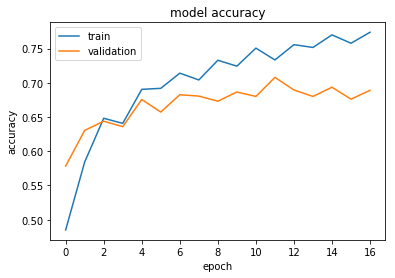

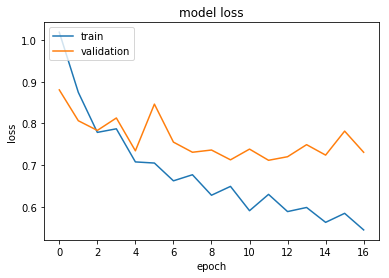

In [0]:
plt.plot(uni_history.history['categorical_accuracy'])
plt.plot(uni_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(uni_history.history['loss'])
plt.plot(uni_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The model accuracy is 0.66 on the test set. This is much better than a random guess, since that would end up with a 66% chance. In the previous runs of the model different versions have been tested, but all seem to have similar results. Switching the LSTM to a CuDNNLSTM sped up the process by a lot, without many drawbacks. Even though the dropout and recurrent dropout couldn't be used. A dropout layer was added, but the results are similar.

## Bidirectional RNN Model for document level sentiment classification

### Model

In [0]:
vocab_size = len(words_idx)
bimodel = Sequential()
bimodel.add(Embedding(vocab_size, 300, mask_zero=False, name='Word-Embedding'))
bimodel.add(Dropout(dropout))
bimodel.add(Dense(32))
bimodel.add(Dropout(dropout))
bimodel.add(Bidirectional(CuDNNLSTM(300, return_sequences=False, name='GPU-LSTM')))
bimodel.add(Dense(3, name='Dense'))
bimodel.add(Activation('softmax'))

In [0]:
optimizer = opt.RMSprop(lr=0.001, rho=0.9, epsilon=1e-06, clipnorm=10, clipvalue=0)
bimodel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
bimodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Word-Embedding (Embedding)   (None, None, 300)         3000900   
_________________________________________________________________
dropout_31 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
dense_17 (Dense)             (None, None, 32)          9632      
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 600)               801600    
_________________________________________________________________
Dense (Dense)                (None, 3)                 1803      
_________________________________________________________________
activation_20 (Activation)   (None, 3)                 0         
Total para

### Training

In [0]:
bi_history = train_generator(bimodel, batch_train_iter, batch_val_iter, bi_checkpoint_path, epochs, patience)

Epoch 1/30
391/390 [==============================] - 71s 182ms/step - loss: 1.0128 - categorical_accuracy: 0.4774 - val_loss: 0.8746 - val_categorical_accuracy: 0.5714
Epoch 2/30
391/390 [==============================] - 70s 179ms/step - loss: 0.8748 - categorical_accuracy: 0.5843 - val_loss: 0.8052 - val_categorical_accuracy: 0.6295
Epoch 3/30
391/390 [==============================] - 70s 180ms/step - loss: 0.7979 - categorical_accuracy: 0.6394 - val_loss: 0.8849 - val_categorical_accuracy: 0.6101
Epoch 4/30
391/390 [==============================] - 70s 179ms/step - loss: 0.7658 - categorical_accuracy: 0.6618 - val_loss: 0.7386 - val_categorical_accuracy: 0.6647
Epoch 5/30
391/390 [==============================] - 70s 179ms/step - loss: 0.7051 - categorical_accuracy: 0.6958 - val_loss: 0.8063 - val_categorical_accuracy: 0.6344
Epoch 6/30
391/390 [==============================] - 70s 179ms/step - loss: 0.7235 - categorical_accuracy: 0.6792 - val_loss: 0.7329 - val_categorical_acc

### Evaluate

In [0]:
bimodel.evaluate(test_x_,test_y)

1000/1000 [==============================] - 2s 2ms/step


[0.6485114631652832, 0.728]

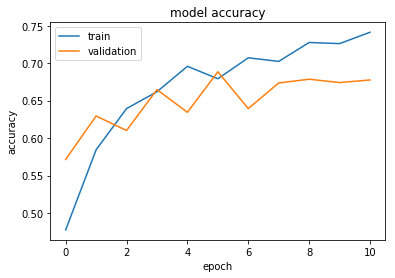

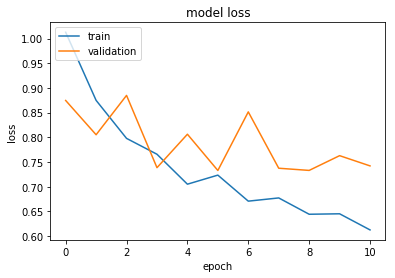

In [0]:
plt.plot(bi_history.history['categorical_accuracy'])
plt.plot(bi_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(bi_history.history['loss'])
plt.plot(bi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Playing around with different architectures did not result in an increase for the test set accuracy. This remained 65%, adding more dropouts to the architecture did result in less overfitting during training.
Using a GPU-accelerated LSTM resulted in a very significant speedup for the method, however the CuDNNLSTM does not allow for dropout or recurrent dropout. so this was partially fixed by adding dropouts, however this will not have the same effect. It's clearly a tradeoff between speed and precision.
Overal 65% is not bad, since a random guess would be 33%